In [48]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import multiprocessing
plt.style.use('dark_background')

In [49]:
filename = "../Domain/data/dataset.pkl"

In [56]:
with open(filename, "rb") as handle:
    # List all groups
    f = pickle.load(handle)
    features = f['features']
    labels   = f['labels']
    feat_names   = f['feat_names']

In [57]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([27521,  8123]))

In [89]:
features = np.where(features<=0, -99, features)

In [99]:
missing = np.sum(np.where(features == -99, 1, 0))
valid   = np.sum(np.where(features != -99, 1, 0))

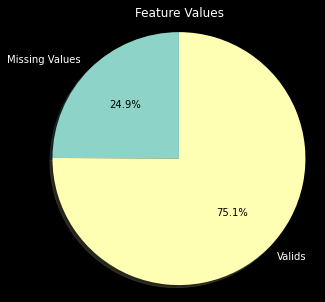

In [109]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Missing Values', 'Valids'
sizes = [missing, valid]

fig1, ax1 = plt.subplots(figsize=(5,5))
_, _, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)


for autotext in autotexts:
    autotext.set_color('Black')
    
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Feature Values')
plt.show()

In [62]:
parameters = {"n_estimators": [1000], 
              "max_depth": [None], 
              "class_weight":["balanced_subsample"],
              "n_jobs":[multiprocessing.cpu_count()]}

clf = GridSearchCV(RandomForestClassifier(), parameters)
clf.fit(features, labels)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced_subsample'],
                         'max_depth': [None], 'n_estimators': [1000],
                         'n_jobs': [8]})

In [119]:
print('CV ACC: {:.2f} +- {:.2f}'.format(clf.cv_results_['mean_test_score'][0], clf.cv_results_['std_test_score'][0]))

CV ACC: 0.78 +- 0.03


In [70]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [71]:
model = RandomForestClassifier(n_estimators=clf.best_estimator_.n_estimators, 
                               max_depth=None, 
                               class_weight='balanced_subsample', 
                               n_jobs=multiprocessing.cpu_count())
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=8)

In [72]:
y_pred = model.predict(x_test)

In [113]:
precision, recall, f1, supp = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Precision:{:.2f}\nRecall:{:.2f}\nF1:{:.2f}'.format(precision, recall, f1))

Precision:0.91
Recall:0.90
F1:0.91


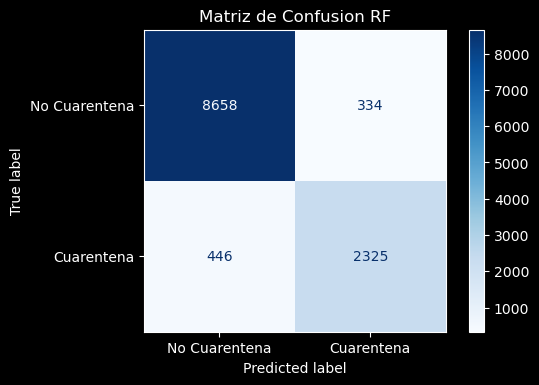

In [78]:
fig, ax = plt.subplots(1,1, dpi=100)
disp = plot_confusion_matrix(model, x_test, y_test,
                             display_labels=['No Cuarentena', 'Cuarentena'],
                             cmap=plt.cm.Blues,
                             normalize=None, ax=ax)
ax.set_title('Matriz de Confusion RF')
fig.savefig('./cm.png', format='png')

In [79]:
sorted_indices = np.argsort(model.feature_importances_[:-1], )

importances   = model.feature_importances_[sorted_indices][::-1]
feature_names = np.array(feat_names)[sorted_indices][::-1]

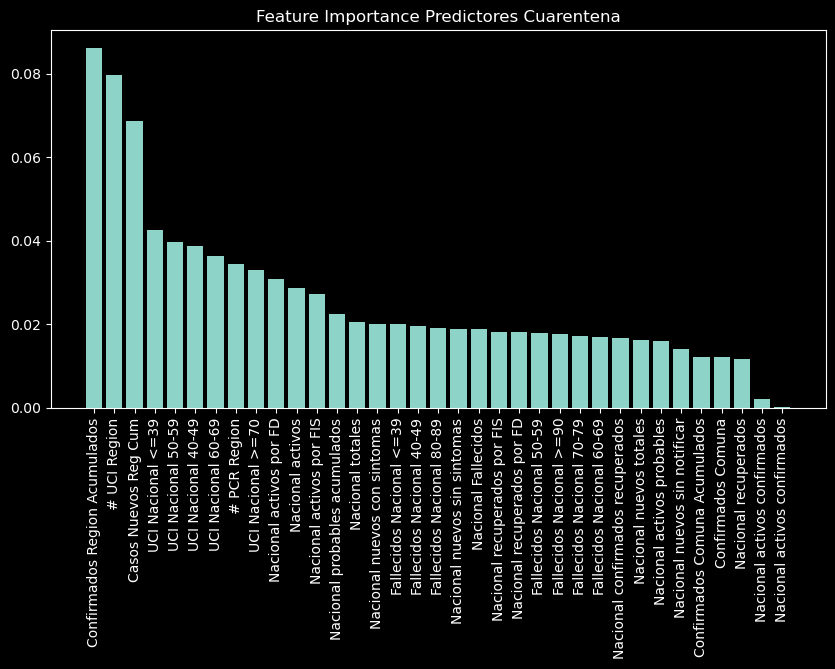

In [80]:
plt.figure(figsize=(10,5), dpi=100)
plt.bar(range(0, len(importances)), importances, align='center')
plt.xticks(range(0, len(importances)), feature_names, rotation=90)
plt.title('Feature Importance Predictores Cuarentena')
plt.savefig('./importance.png', format='png', bbox_inches='tight')
plt.show()